In [1]:
from __future__ import print_function, division
import scipy
from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds

Using TensorFlow backend.


In [7]:
from PIL import Image
from glob import glob
import imageio
class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./tensorflow_datasets/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = imageio.imread(img_path)
            if not is_testing:
                img = np.array(Image.fromarray(img).resize(size=self.img_res))

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = np.array(Image.fromarray(img).resize(size=self.img_res))
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        path_A = glob('./tensorflow_datasets/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./tensorflow_datasets/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = imageio.imread(img_A)
                img_B = imageio.imread(img_B)

                img_A = np.array(Image.fromarray(img_A).resize(size=self.img_res))
                img_B = np.array(Image.fromarray(img_B).resize(size=self.img_res))

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B


In [8]:
class CycleGAN():
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)
        self.gf = 32
        self.df = 64
        self.lambda_cycle = 10.0
        self.lambda_id = 0.9 * self.lambda_cycle
        self.optimizer = Adam(0.0002, 0.5)
        self.data_loader = DataLoader('apple2orange', img_res=(self.img_rows, self.img_cols))
        
    def build(self):
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse', optimizer=self.optimizer, metrics=['accuracy'])
        self.d_B.compile(loss='mse', optimizer=self.optimizer, metrics=['accuracy'])
        
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()
        
        img_A = Input(shape = self.img_shape)
        img_B = Input(shape = self.img_shape)
        
        fake_A = self.g_BA(img_B)
        fake_B = self.g_AB(img_A)
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)
        
        self.d_A.trainable = False
        self.d_B.trainable = False
        
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)
        
        self.combined = Model(inputs=[img_A, img_B], 
                              outputs=[valid_A, valid_B, reconstr_A, reconstr_B, img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
                              loss_weights=[1, 1, self.lambda_cycle, self.lambda_cycle, self.lambda_id, self.lambda_id],
                              optimizer=self.optimizer)
        
    def build_generator(self):
        
        def conv2d(layer_input, filters, f_size=4):
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d
            
        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u
        
        d0 = Input(shape=self.img_shape)
        
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf * 2)
        d3 = conv2d(d2, self.gf * 4)
        d4 = conv2d(d3, self.gf * 8)
        
        u1 = deconv2d(d4, d3, self.gf * 4)
        u2 = deconv2d(u1, d2, self.gf * 2)
        u3 = deconv2d(u2, d1, self.gf)
        
        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)
        
        return Model(d0, output_img)
    
    def build_discriminator(self):
        
        def d_layer(layer_input, filters, f_size=4, normalization=True):
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d
        
        img = Input(shape=self.img_shape)
        
        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df * 2)
        d3 = d_layer(d2, self.df * 4)
        d4 = d_layer(d3, self.df * 8)
        
        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
        
        return Model(img, validity)
    
    def train(self, epochs, batch_size = 1, sample_interval=50):
        start_time = datetime.datetime.now()
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.ones((batch_size,) + self.disc_patch)
        
        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)
                
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_fake, dA_loss_real)
                
                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_fake, dB_loss_real)
                
                d_loss = 0.5 * np.add(dB_loss, dA_loss)
                
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, valid, imgs_A, imgs_B, imgs_A, imgs_B])
                
                if batch_i % sample_interval == 0:
                    print('epoch: {0}, d loss: {1}, g loss: {2}'.format(epoch, d_loss, g_loss))
                    self.sample_images(epoch, batch_i)
                    
    def sample_images(self, epoch, batch_i):
        r, c = 2, 3
        
        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)
        
        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

In [16]:
cycleGAN = CycleGAN()

In [17]:
cycleGAN.build()

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, d loss: [7.543829   0.15234375], g loss: [170.23613, 92.40319, 42.58852, 1.0549653, 1.1169034, 0.9534173, 0.5494413]


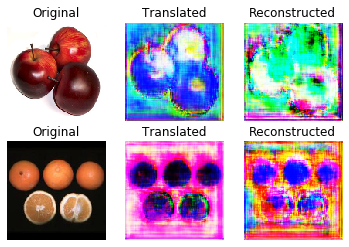

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


FailedPreconditionError:  Error while reading resource variable _AnonymousVar1296 from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/_AnonymousVar1296/class tensorflow::Var does not exist.
	 [[node mul_1392/ReadVariableOp (defined at C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_87451]

Function call stack:
keras_scratch_graph


In [18]:
cycleGAN.train(epochs=100, batch_size=16, sample_interval=10)